In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import special
from tqdm import tqdm
from scipy.optimize import curve_fit
import scipy.integrate as integrate
from IPython.display import Image
from IPython.display import Markdown
import os

# Science Case 1 - Tratamento de Dados Astronômicos 2023B

## Medir as larguras equivalentes da linha de absorção He I 4471 a partir de um ajuste do Perfil de Voigt

A largura equivalente de uma linha espectral nos indica a abundância do íon representado por essa linha. Para estrelas de alta massa, temos que a linha de He I no comprimento de onda 4471 Ang, é um indicador de temperatura e, por isso, saber a sua abundância é importante.

Na imagem abaixo vemos a definição de Largura Equivalente: Largura necessária para que o retângulo de altura igual a 1 seja igual a área abaixo da curva. 

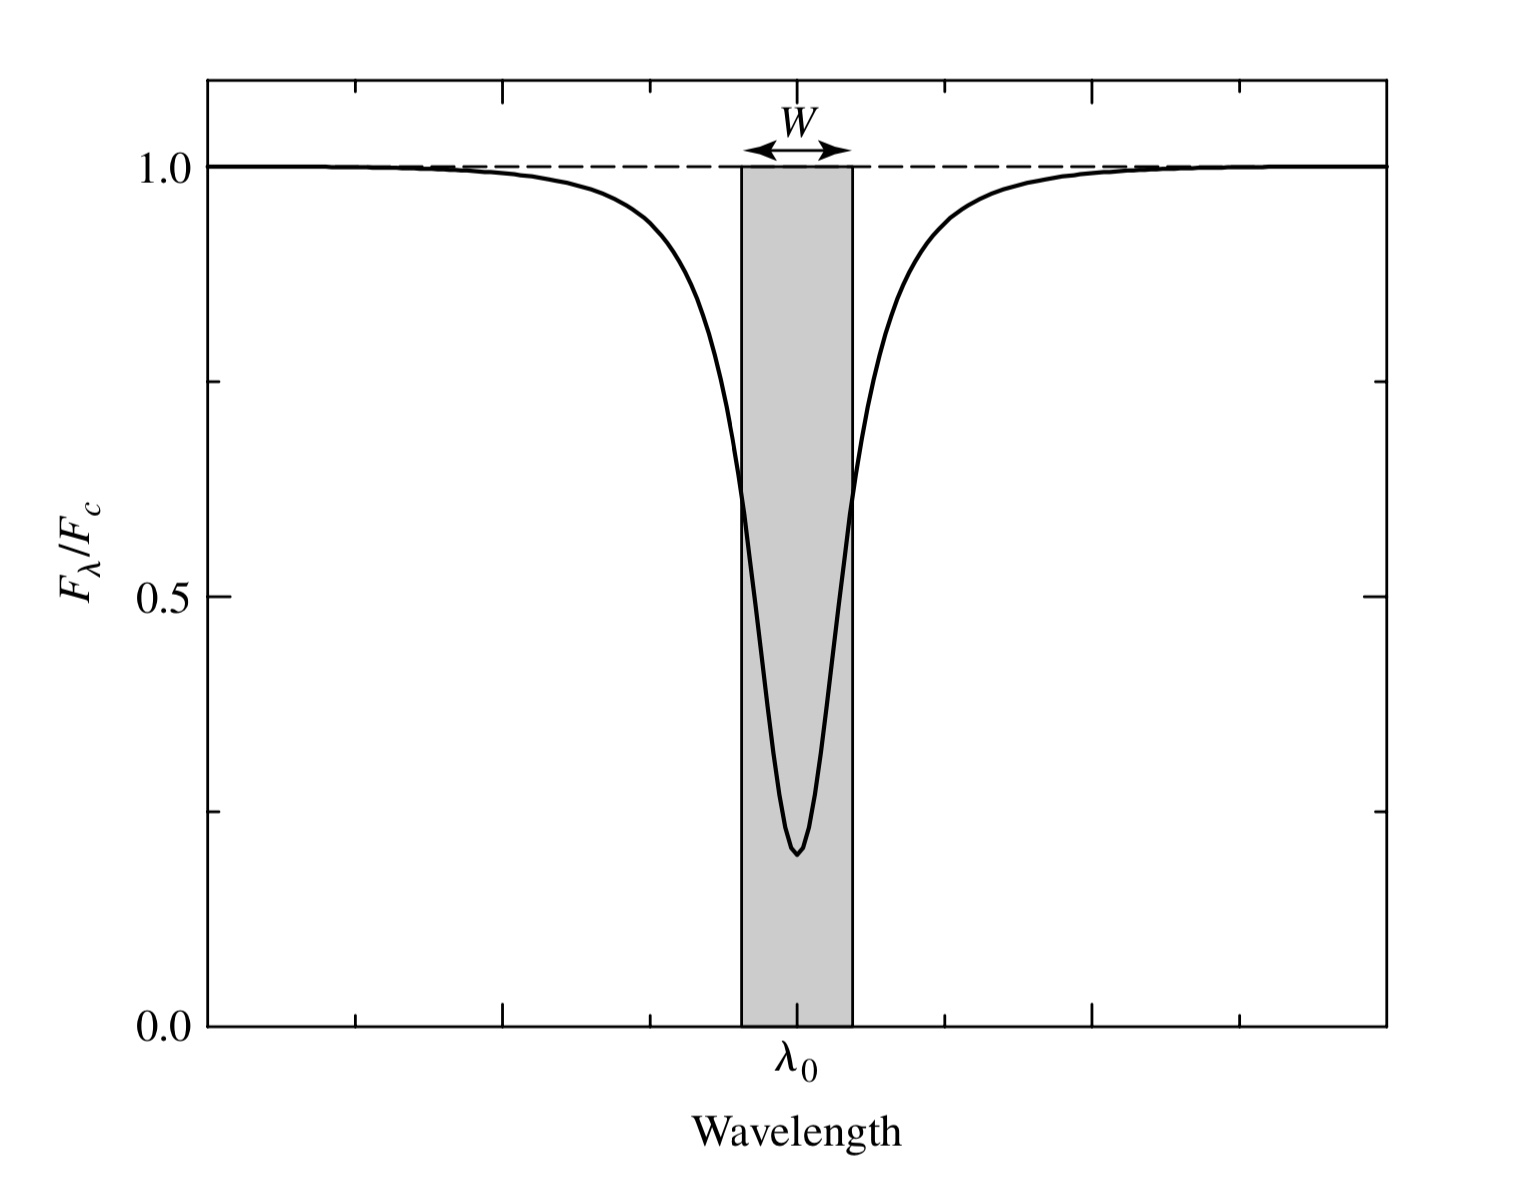

In [2]:
Image(filename = "/Users/juliacamoesalves/Documents/Julia_Alves/Mestrado/Estágio de Docência/Eq_width.jpg", width = 600, height = 300)

Fonte: Carroll, B. W., & Ostlie, D. A. (2017). An introduction to modern astrophysics. Cambridge University Press.

Abaixo vemos uma demonstração de um processo de integração.

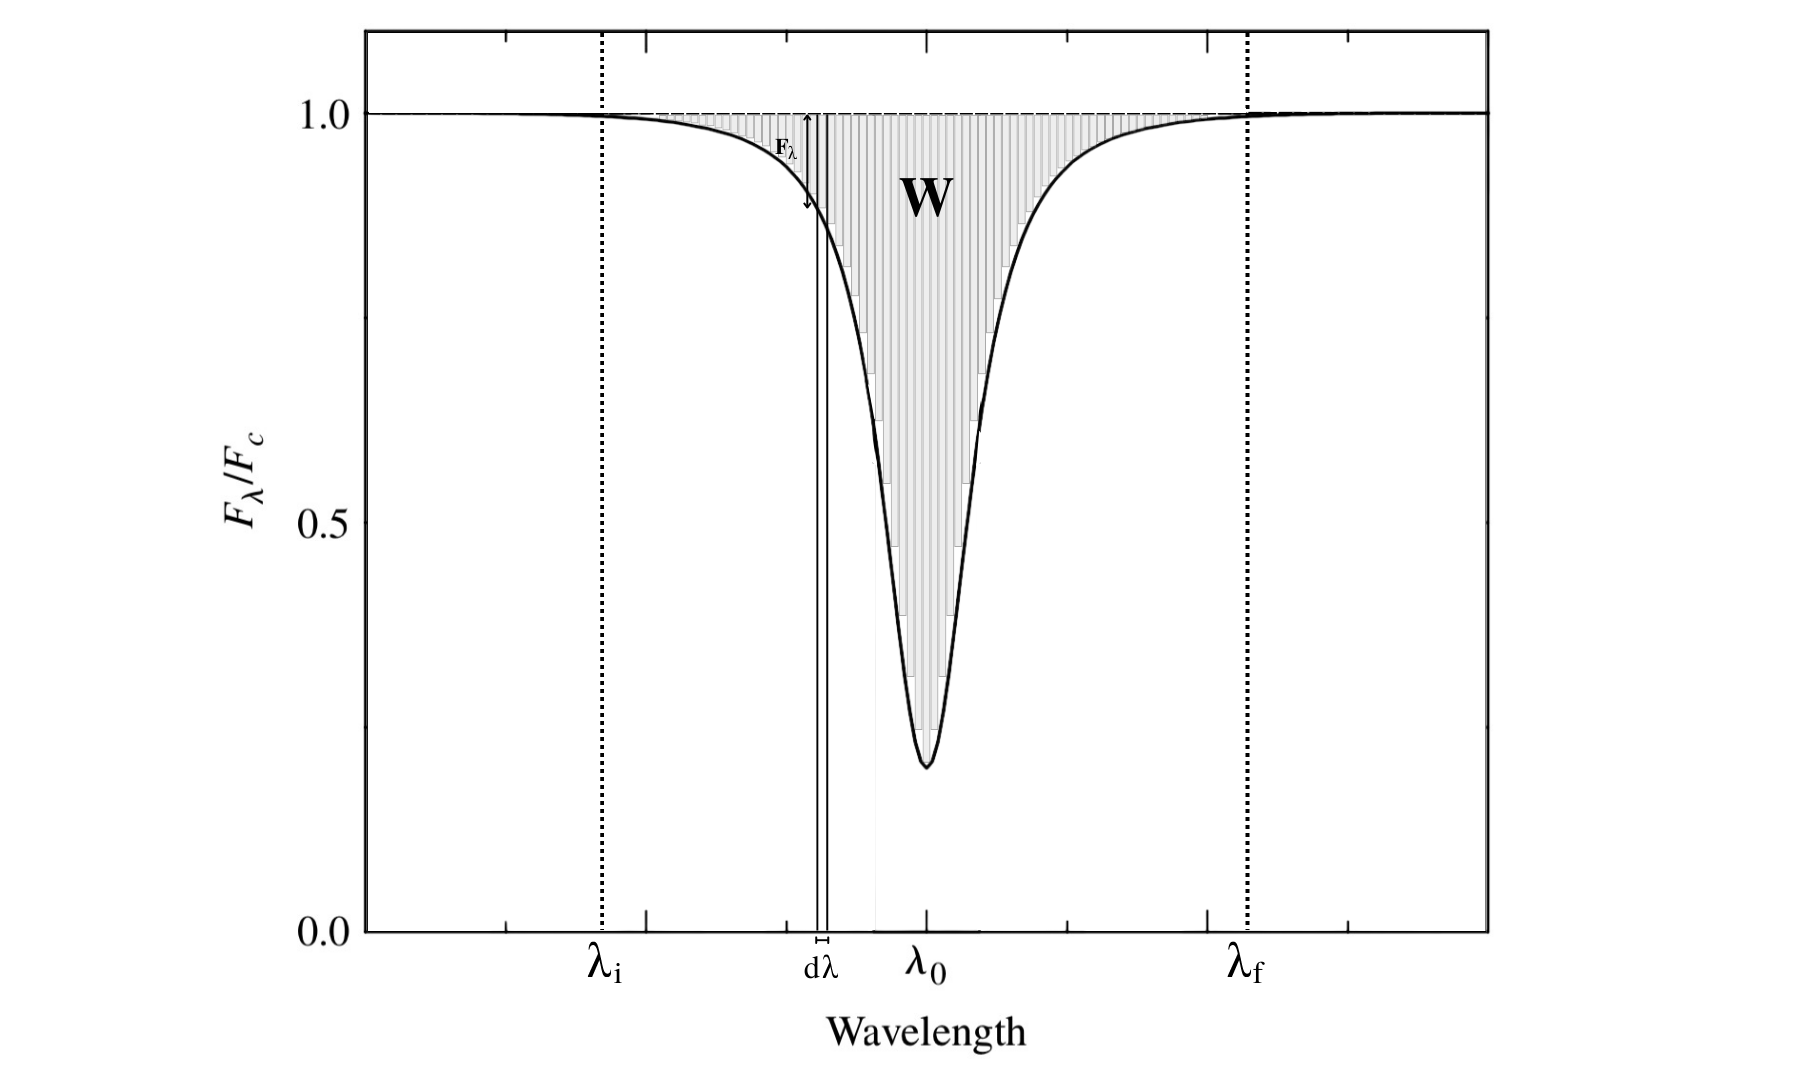

In [3]:
Image(filename = "/Users/juliacamoesalves/Documents/Julia_Alves/Mestrado/Estágio de Docência/eq_width_int.png", width = 800, height = 300)

A medida de largura equivalente pode ser feita de formas diferentes, mas para esse exercício, faremos a partir do ajuste de função de Voigt ao perfil da linha de absorção. Quando fizermos o ajuste dessa função, faremos a integração da área abaixo da curva que será o valor da largura equivalente.

### Comparação entre os perfis Gaussiano, Lorentziano e de Voigt:

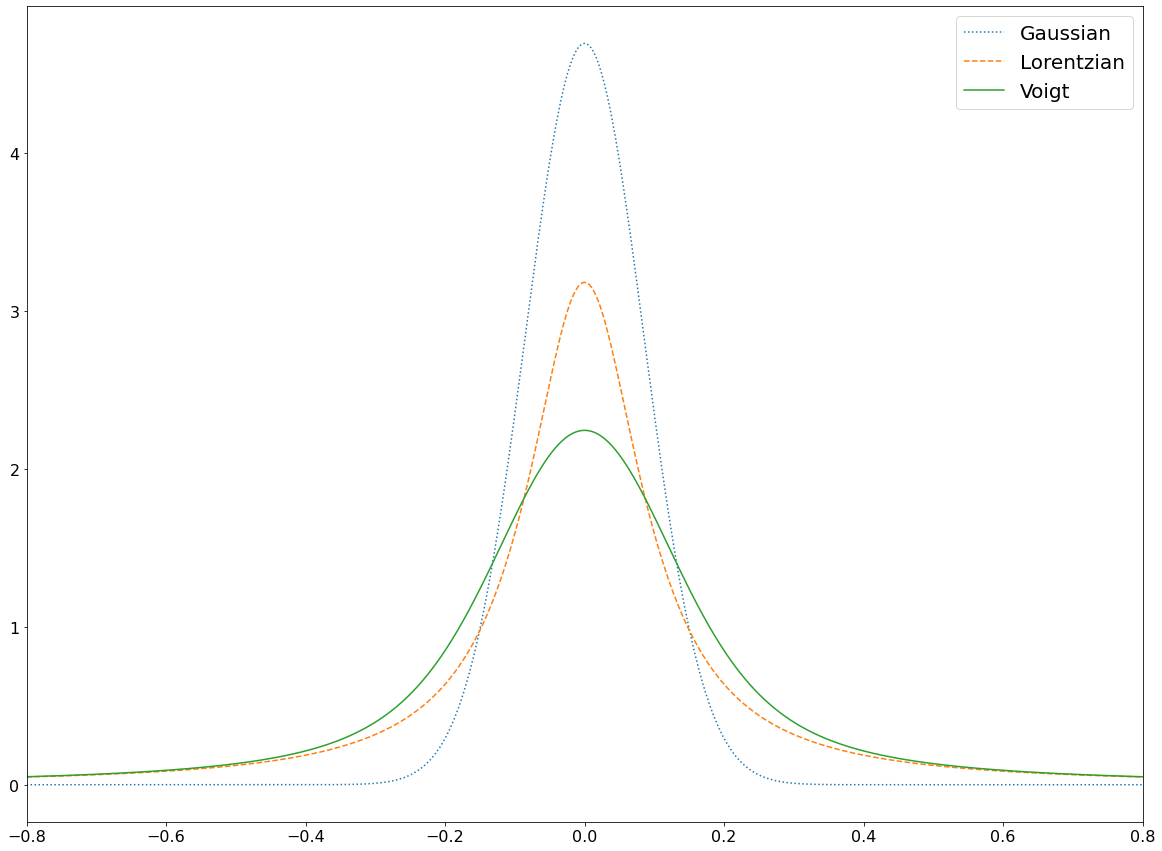

In [4]:
import numpy as np
from scipy.special import wofz
import pylab

def G(x, alpha):
    """ Return Gaussian line shape at x with HWHM alpha """
    return np.sqrt(np.log(2) / np.pi) / alpha\
                             * np.exp(-(x / alpha)**2 * np.log(2))

def L(x, gamma):
    """ Return Lorentzian line shape at x with HWHM gamma """
    return gamma / np.pi / (x**2 + gamma**2)

def V(x, alpha, gamma):
    """
    Return the Voigt line shape at x with Lorentzian component HWHM gamma
    and Gaussian component HWHM alpha.

    """
    sigma = alpha / np.sqrt(2 * np.log(2))

    return np.real(wofz((x + 1j*gamma)/sigma/np.sqrt(2))) / sigma\
                                                           /np.sqrt(2*np.pi)


pylab.figure(figsize=(20, 15))
alpha, gamma = 0.1, 0.1
x = np.linspace(-0.8,0.8,1000)
pylab.plot(x, G(x, alpha), ls=':', label='Gaussian')
pylab.plot(x, L(x, gamma), ls='--', label='Lorentzian')
pylab.plot(x, V(x, alpha, gamma), label='Voigt')
pylab.xlim(-0.8,0.8)
pylab.xticks(fontsize=16)
pylab.yticks(fontsize=16)
pylab.legend(prop={'size': 20})
pylab.show()

## O Perfil de Voigt é definido da seguinte forma:


$V(z; \sigma, \gamma) = \frac{Re[w(z)]}{\sigma\sqrt{2\pi}}$

Sendo $z = \frac{x+i\gamma}{\sqrt{2}\sigma}$

**Para realizarmoso o ajuste do Perfil de Voigt, utilizaremos a função do Scipy: scipy.special.voigt_profile(x, sigma, gamma)**


### Curiosidade: 

Neste projeto, utilizaremos espectros de alta resolução de estrelas de alta massa. Alguns exemplos estão expostos abaixo. 

Warning! Os objetos utilizados não são os representados na imagem abaixo.

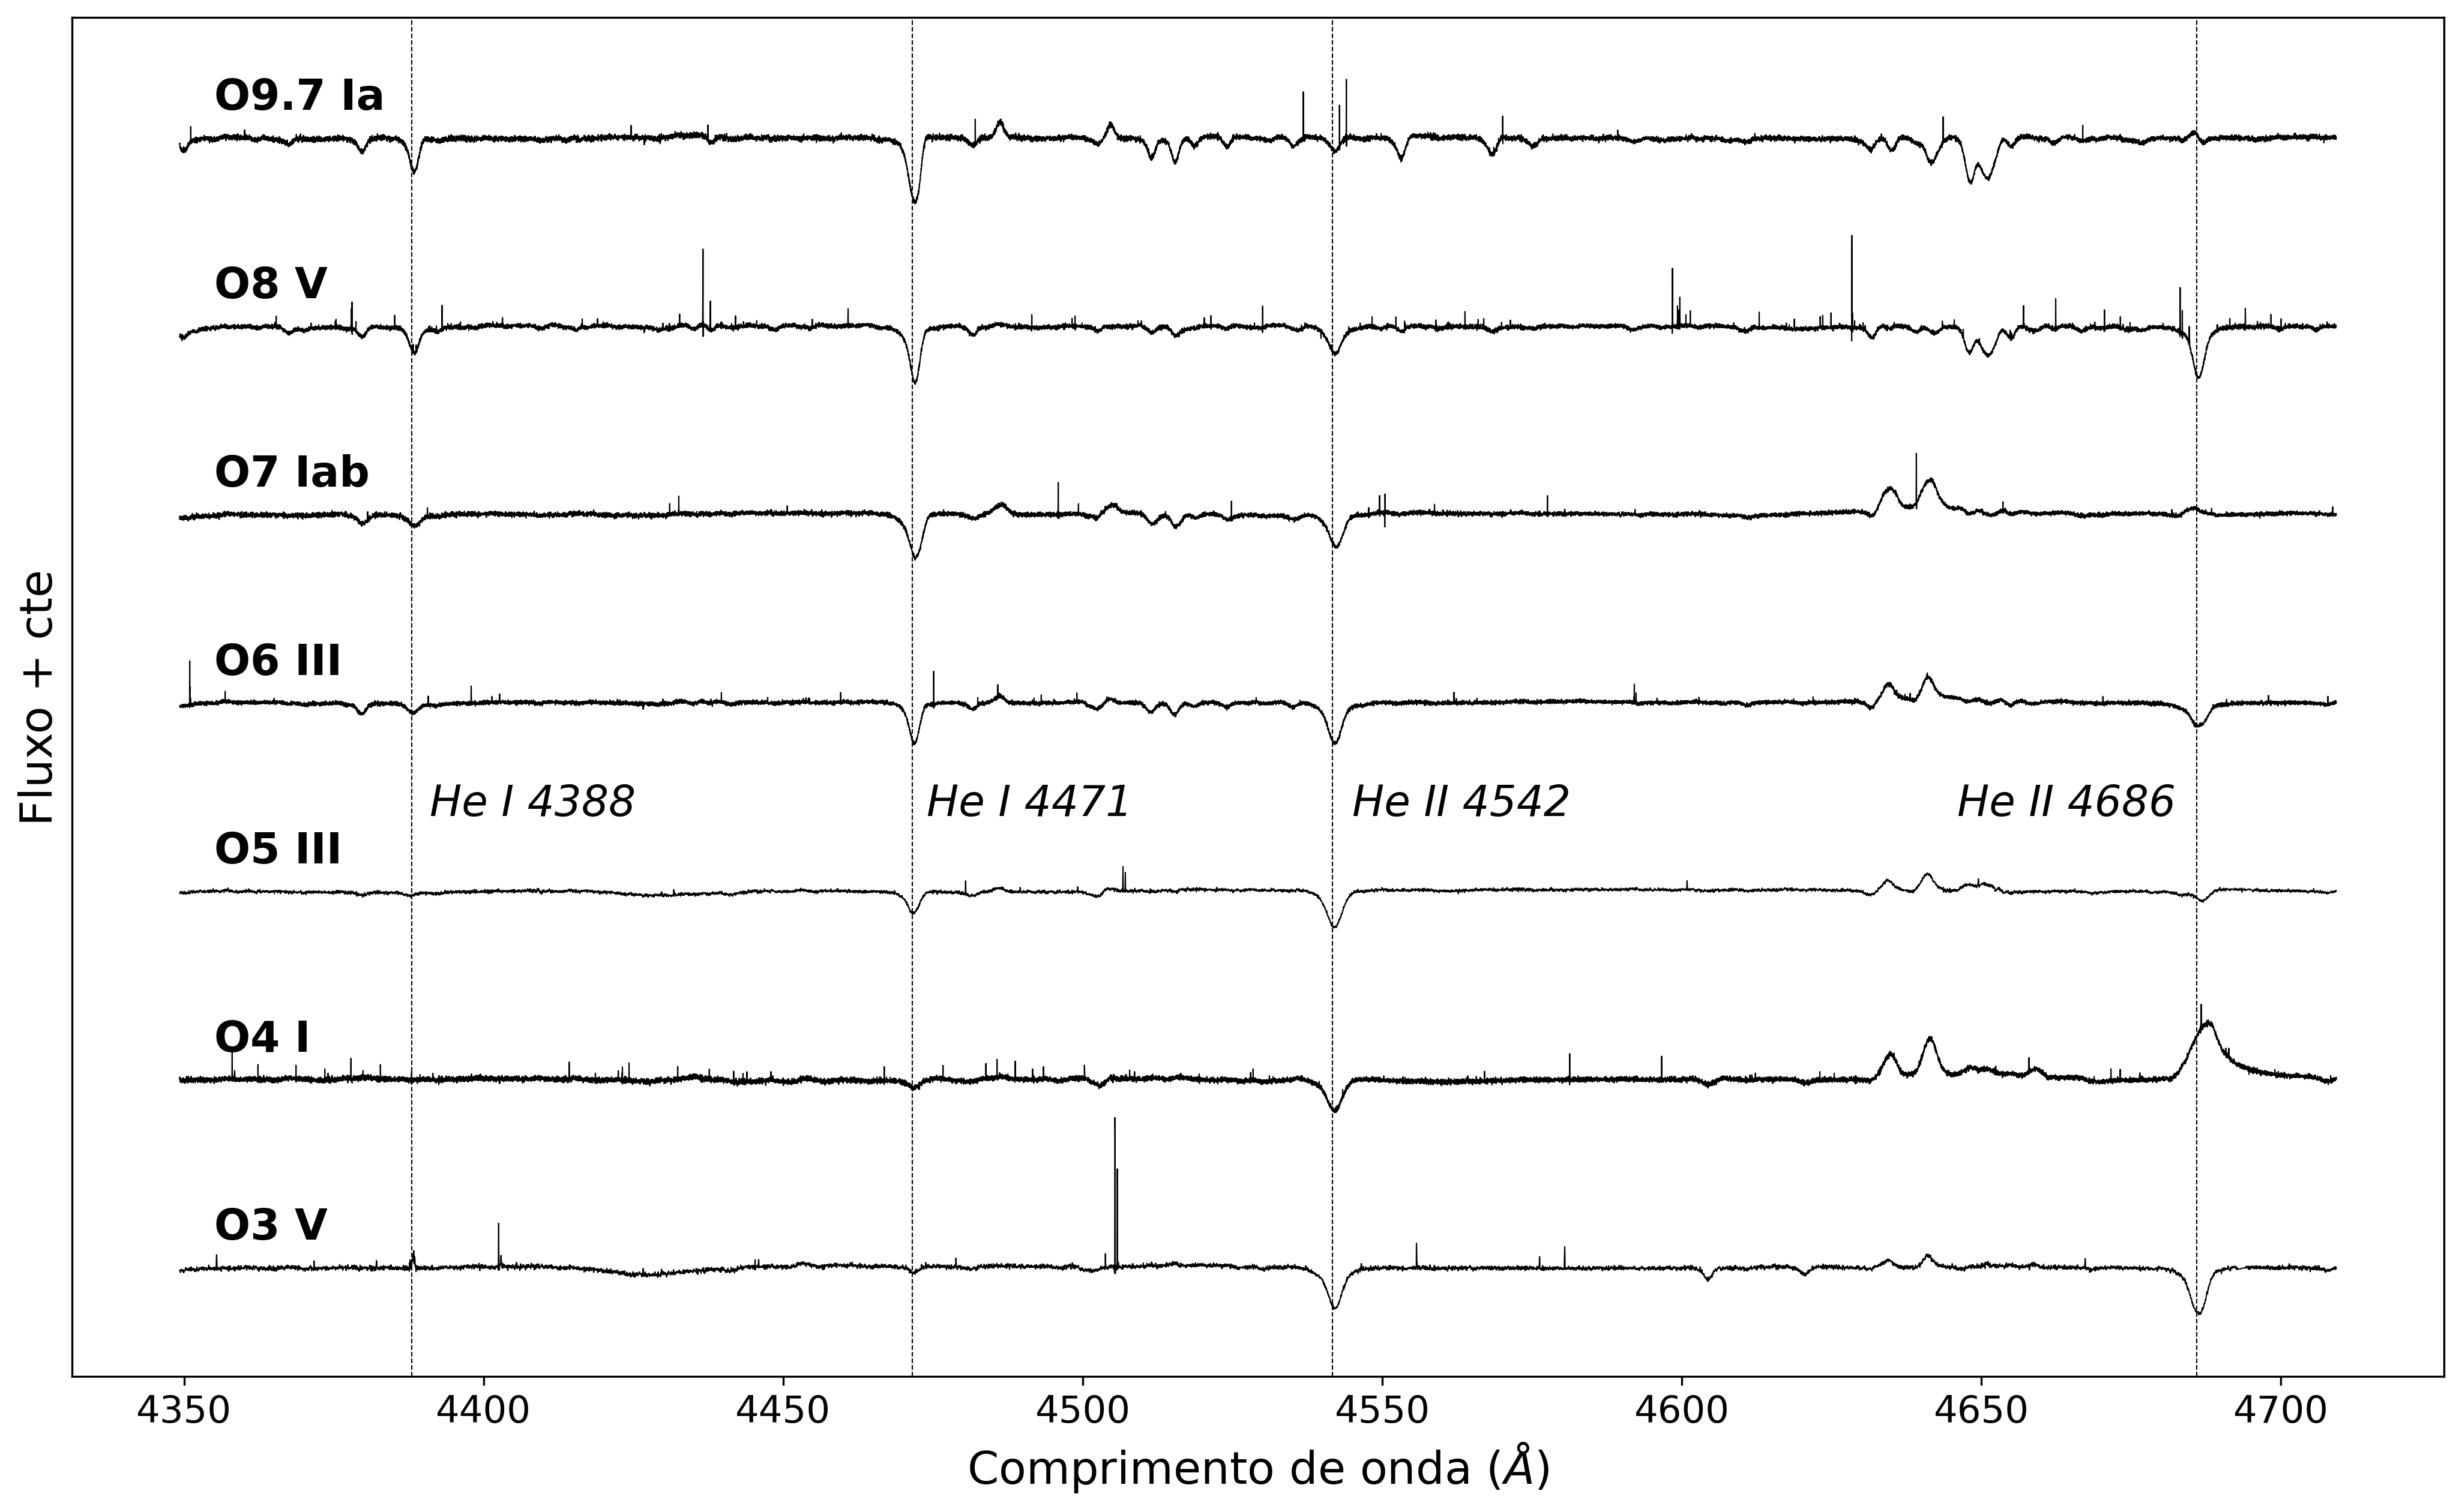

In [3]:
Image(filename = "/Users/juliacamoesalves/Documents/Julia_Alves/Mestrado/Estágio de Docência/Espectros_AltaR.png", width = 1000, height = 300)

## Este projeto estará separado em 4 partes:

### Pte 1. Abrir o arquivo e separar os valores de comprimento de onda e de fluxo no intervalo entre 4468. e 4477. Ang.;

### Pte 2. Centralizar a linha para realizarmos o ajuste com o Perfil de Voigt teórico;

### Pte 3. Suavizar o espectro observado para facilitar o ajuste;

### Pte 4. Ajustar o espectro observado suavizado ao perfil de Voigt teórico formado a partir de diferentes combinações de parâmetros de sigma e gamma e comparar com os resultados da função curve_fit;

### Pte 5. Encontrar a Largura Equivalente.



--------------------


## Definimos as funções que serão utilizadas no processo:

**Função que define os comprimentos de onda nos quais o fluxo é igual ao FWHM**

In [4]:
def lambdas_fwhm(x, y): #Definimos a função FWHM para determinarmos os intervalos de comprimento de onda da largura à meia altura
    
    list_index=[]
    
    min_flux = 1-(1-y[y.argmin()])/2 #Encontramos o valor de fluxo mínimo
    
    difference_array = np.absolute(y-min_flux) #Função que nos dá a diferença entre todos os itens de fluxo 
                                               # e o valor de fluxo mínimo
    
    index_min = difference_array.argmin() #Função que nos retorna a menor diferença
    
    list_index.append(index_min) # Adiciona o index do item mínimo à lista
    
    difference_array = np.delete(difference_array, index_min) # Deleta esse mínimo para que possamos buscar o segundo mínimo
    
    index_min = difference_array.argmin()
    
    list_index.append(index_min)
    
    lams_fwhm = [x[list_index[0]], x[list_index[1]]] # Posições de comprimento de onda o fluxo é o mais próximo 
                                                     #do fluxo à meia altura
    return lams_fwhm

**Função que define o Perfil de Voigt**

In [5]:
def perfil_voigt(x, sigma, gamma): #Definição do perfil de Voigt para linhas espectrais de absorção
    return -scipy.special.voigt_profile(x, sigma, gamma)+1

**Exemplo teórico:**


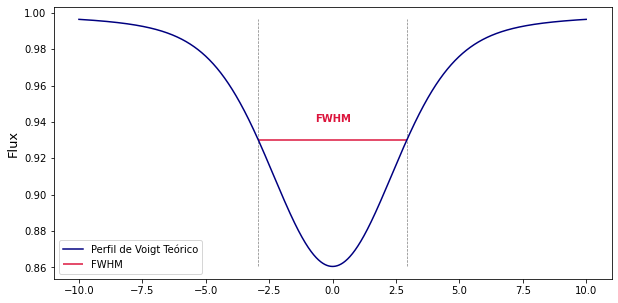

In [6]:
x = np.linspace(-10, 10, 2000) # Valores de x 

y = perfil_voigt(x, 2, 1) # Perfil de Voigt com sigma = 2 e gamma = 1

l = lambdas_fwhm(x, y)

plt.figure(figsize=(10, 5))
plt.plot(x, y, color= 'navy', label = 'Perfil de Voigt Teórico')
plt.hlines(y=1-(1-min(y))/2, xmin = l[0], xmax = l[1], color = 'crimson', label = 'FWHM')
plt.vlines(x = l[0], ymin = min(y), ymax = max(y), linestyle = '--', color = 'gray', linewidth = 0.7)
plt.vlines(x = l[1], ymin = min(y), ymax = max(y), linestyle = '--', color = 'gray', linewidth = 0.7)
plt.text(-0.7, 0.94, 'FWHM', color = 'crimson', weight='bold')
plt.legend()
plt.ylabel('Flux', fontsize = 13)
plt.show()

In [7]:
def center_spec(x, y): #Centralizaremos o espectro observado a partir dos valores de lambda encontrados em lambdas_fwhm(x, y)
    lams = lambdas_fwhm(x, y)
    center = lams[0]+(lams[1]-lams[0])/2 # Posição no eixo x que marca o centro da curva
    center_y = []
    for i in x:
        if center-0.1 < i < center+0.1: # Encontrar o valor nos pontos x que seja o mais próximo do centro determinado
            center_y.append(i)
            break
    return center_y[0]

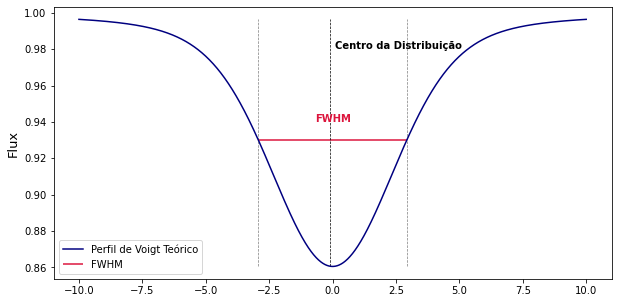

In [8]:
#Código para plotar a função

plt.figure(figsize=(10, 5))
plt.plot(x, y, color= 'navy', label = 'Perfil de Voigt Teórico')
plt.hlines(y=1-(1-min(y))/2, xmin = l[0], xmax = l[1], color = 'crimson', label = 'FWHM')
plt.vlines(x = l[0], ymin = min(y), ymax = max(y), linestyle = '--', color = 'gray', linewidth = 0.7)
plt.vlines(x = l[1], ymin = min(y), ymax = max(y), linestyle = '--', color = 'gray', linewidth = 0.7)
plt.vlines(x=center_spec(x,y), ymin = min(y), ymax = max(y), color = 'black', linestyle = '--', linewidth=0.7)
plt.text(-0.7, 0.94, 'FWHM', color = 'crimson', weight='bold')
plt.text(0.1, 0.98, 'Centro da Distribuição', color = 'black', weight='bold')
plt.legend()
plt.ylabel('Flux', fontsize = 13)
plt.show()

**Função para suavizar o espectro observado e facilitar o ajuste do modelo**

In [9]:
def smooth(y, box_pts): #Função de convolução para suavizar o espectro observado 
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

### Pte 1. Abrir o espectro e definir o intervalo de comprimento de onda

In [10]:
#Abrir o arquivo que contém o espectro

archive=open('/Users/juliacamoesalves/Documents/Julia_Alves/Mestrado/Estágio de Docência/Espectros_ProjetoI/hd155889_mimes_O9p5IV_rvcor.norm',"r")

lines=archive.readlines() # Função para ler as linhas do arquivo 

lines[:10]

['3782.4702 0.7888\n',
 '3782.4822 0.7929\n',
 '3782.4941 0.8173\n',
 '3782.5061 0.8252\n',
 '3782.5181 0.8452\n',
 '3782.5293 0.8667\n',
 '3782.5413 0.8719\n',
 '3782.5532 0.9027\n',
 '3782.5652 0.9359\n',
 '3782.5771 0.9340\n']

In [11]:
#Ler as linhas contidas no arquivo

lambdas=[]
flux=[]

for i in lines:
    values = i.split() #Aqui separamos os valores de comprimento de onda e de fluxo
    if '4468' < values[0] < '4477':
        lambdas.append(float(values[0])) # Valores de comprimento de onda
        flux.append(float(values[1])) # Valores de fluxo
    else:
        continue

archive.close()

O centro da linha de absorção está em: 4472.564


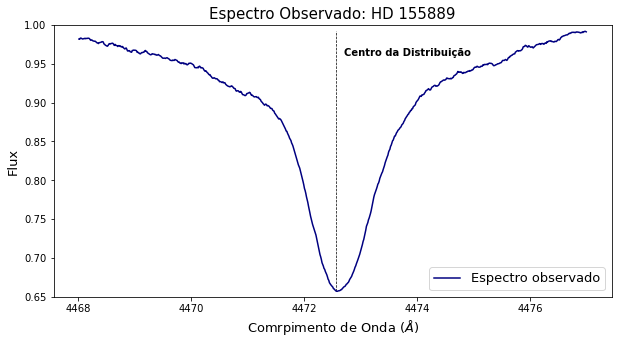

In [12]:
lambdas = np.array(lambdas)
flux = np.array(flux)

c = center_spec(lambdas, flux)
print('O centro da linha de absorção está em: {}'.format(round(c, 3)))

x_center_index= int(np.where(lambdas == c)[0]) #Comprimento de onda central

plt.figure(figsize=(10, 5))
plt.plot(lambdas, flux, color= 'navy', label = 'Espectro observado')
plt.vlines(x = c, ymin = min(flux), ymax = max(flux), linestyle = '--', color = 'black', linewidth = 0.7)
plt.text(4472.7, 0.96, 'Centro da Distribuição', color = 'black', weight='bold')
plt.title('Espectro Observado: HD 155889', fontsize = 15)
plt.legend(loc = 'lower right', fontsize = 13)
plt.ylabel('Flux', fontsize = 13)
plt.xlabel(r'Comrpimento de Onda ($\AA$)', fontsize = 13)
plt.ylim(0.65, 1.)
plt.show()

### Pte 2. Centralizar o espectro para realizar a comparação com o perfil de Voigt

In [13]:
points= len(lambdas) - x_center_index # Quantidade de pontos até atingir o centro da linha

x=[]
y=[]
    
for i in range((2*points)): # Termos o mesmo número de pontos em ambos os lados do centro da linha
    if (x_center_index-points+i) > 0: 
        x.append(lambdas[x_center_index-points+i]) #Intervalo de comprimento de onda centralizando a linha de absorção
        y.append(flux[x_center_index-points+i]) #Fluxos correspondentes a esses comprimentos de onda
    else:
        continue

### Pte 3. Suavizar o espectro

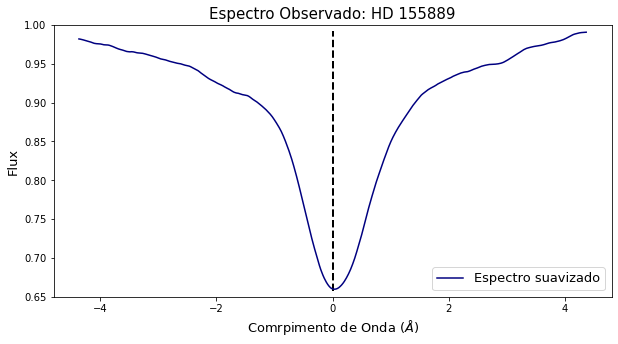

In [14]:
smooth_y=smooth(y, 20) #Fluxo suavizado    
x=np.linspace(-(x[len(x)-1]-x[0])/2,(x[len(x)-1]-x[0])/2,len(x))

plt.figure(figsize=(10, 5))
plt.plot(x[10:-10], smooth_y[10:-10], color= 'navy', label = 'Espectro suavizado')
plt.vlines(x = 0, ymin = min(flux), ymax = max(flux), linestyle = '--', color = 'black', linewidth = 2)
plt.title('Espectro Observado: HD 155889', fontsize = 15)
plt.legend(loc = 'lower right', fontsize = 13)
plt.ylabel('Flux', fontsize = 13)
plt.xlabel(r'Comrpimento de Onda ($\AA$)', fontsize = 13)
plt.ylim(0.65, 1.)
plt.show()

### Pte 4. Gerar diferentes combinações de gamma e de sigma para buscar o melhor ajuste

In [15]:
sigma = np.linspace(0.,2.,1000) #Lista de possíveis valores de sigma
gamma = np.linspace(0.,1.,100) #Lista de possíveis valores de gamma
        
sigma_teste = np.array([])
gamma_teste = np.array([])

S = np.array([])
L = np.array([])


for i in tqdm(range(len(sigma)), 'Testando as combinações de sigma e gamma: '):
    for j in range(len(gamma)):
        y_modelo = -scipy.special.voigt_profile(x, sigma[i], gamma[j])+1
        
        #Cálculo do resíduo para encontrar a combinação de sigma e gamma que gere a menor diferença entre modelo e observado
        residuo = smooth_y - y_modelo 
        sigma_teste = np.append(sigma_teste, sigma[i])
        gamma_teste = np.append(gamma_teste, gamma[j])
        S = np.append(S, np.sum(residuo**2))


Testando as combinações de sigma e gamma: 100%|██████████| 1000/1000 [00:12<00:00, 81.54it/s]


In [16]:
print('Valor ideal de sigma: {:.3e}'.format(sigma_teste[S.argmin()]))
print('Valor ideal de gamma: {:.3e}'.format(gamma_teste[S.argmin()]))

Valor ideal de sigma: 0.000e+00
Valor ideal de gamma: 9.798e-01


In [18]:
#Sigma e Gamma ideais de acordo com o curve_fit

parameters, covariance = curve_fit(perfil_voigt, x, smooth_y) # curve_fit(função, x, y)

print('Pelo curve_fit, o valor ideal de sigma é {:.3e} e o de gamma é {:.3e}'.format(parameters[0], parameters[1]))

Pelo curve_fit, o valor ideal de sigma é 2.053e-05 e o de gamma é 9.843e-01


**Gráfico com o espectro observado original, espectro observado suavizado, perfil de Voigt otimizado por nós e o perfil pelo curve_fit**

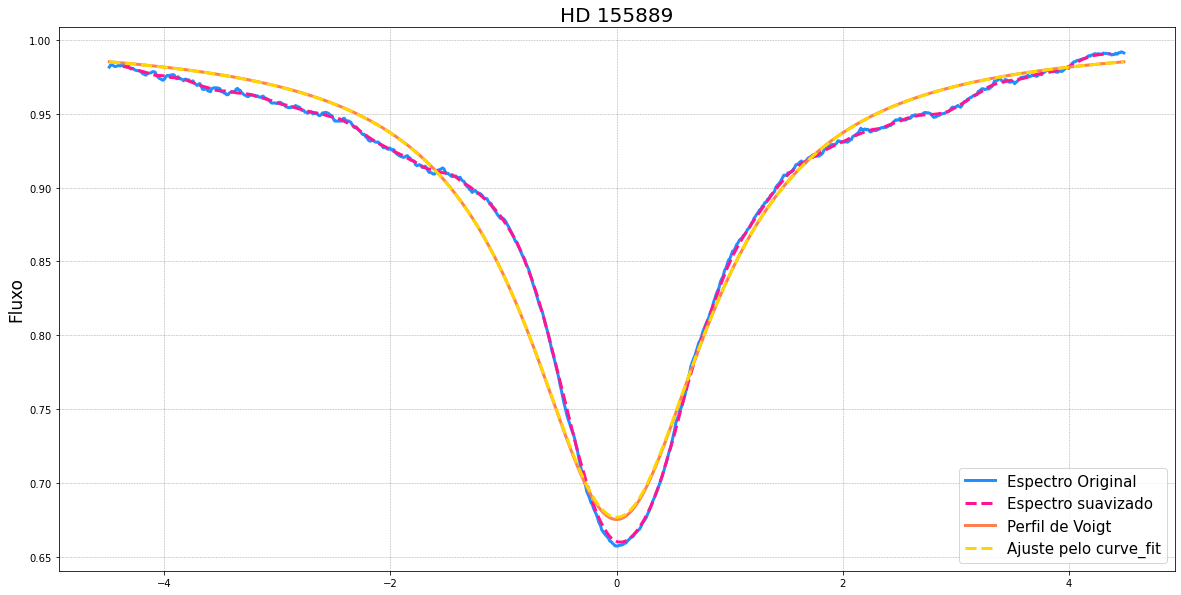

In [19]:
plt.figure(figsize=(20, 10))
plt.plot(x, y, color='dodgerblue', linewidth=3, label='Espectro Original')
plt.plot(x[10:-10], smooth_y[10:-10], color='deeppink', linestyle='--', label='Espectro suavizado',linewidth=3)
plt.plot(x,perfil_voigt(x, sigma_teste[S.argmin()], gamma_teste[S.argmin()]), color='coral', label='Perfil de Voigt',linewidth=3)
plt.plot(x,perfil_voigt(x, parameters[0], parameters[1]), label='Ajuste pelo curve_fit', color='gold', linestyle='--',linewidth=3)
plt.title('HD 155889', fontsize= 20)
plt.legend(loc='lower right', prop={'size':15})
plt.rcParams['figure.figsize'] = (10,5)
plt.ylabel("Fluxo", fontsize= 17)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.show()

## **Calcular a Largura Equivalente**

In [20]:
larg_equivalente = integrate.quad(lambda x: scipy.special.voigt_profile(x, parameters[0], parameters[1]),x[0], x[len(x)-1])
    
print(u'Valor da largura equivalente: {:.3e} \u00B1 {:.3e}'.format(larg_equivalente[0], larg_equivalente[1]))

Valor da largura equivalente: 8.625e-01 ± 6.636e-10


-----------

# Código automático:

In [21]:
# Função para obter os arquivos dos objetos

estrelas = os.listdir('/Users/juliacamoesalves/Documents/Julia_Alves/Mestrado/Estágio de Docência/Espectros_ProjetoI/')
estrelas.remove('.DS_Store')
print('Espectros utilizados: ', estrelas)

Espectros utilizados:  ['hd155889_mimes_O9p5IV_rvcor.norm', 'hd189957_O9p7III_rvcor.norm', 'hd188209_O9p5Iab_rvcor.norm', 'hd156154_mimes_O7p5Ib_rvcor.norm', 'hd225160_O8Iab_rvcor.norm', 'hd218915_mimes_O9p2Iab_rvcor.norm', 'hd193322_mimes_O9IV_rvcor.norm']


In [22]:
# Nomes das estrelas

star_name=['HD 155889', 'HD 189957', 'HD 188209', 'HD 156154', 'HD 225160', 'HD 218915', 'HD 193322']


--------------------------------- #### ----------------------------------------

Estrela:  HD 155889
O centro da linha de absorção está em: 4472.564


Testando as combinações de sigma e gamma: 100%|██████████| 1000/1000 [00:12<00:00, 77.05it/s]


Valor ideal de sigma: 0.000e+00
Valor ideal de gamma: 9.899e-01
Pelo curve_fit, o valor ideal de sigma é 1.841e-04 e o de gamma é 9.853e-01


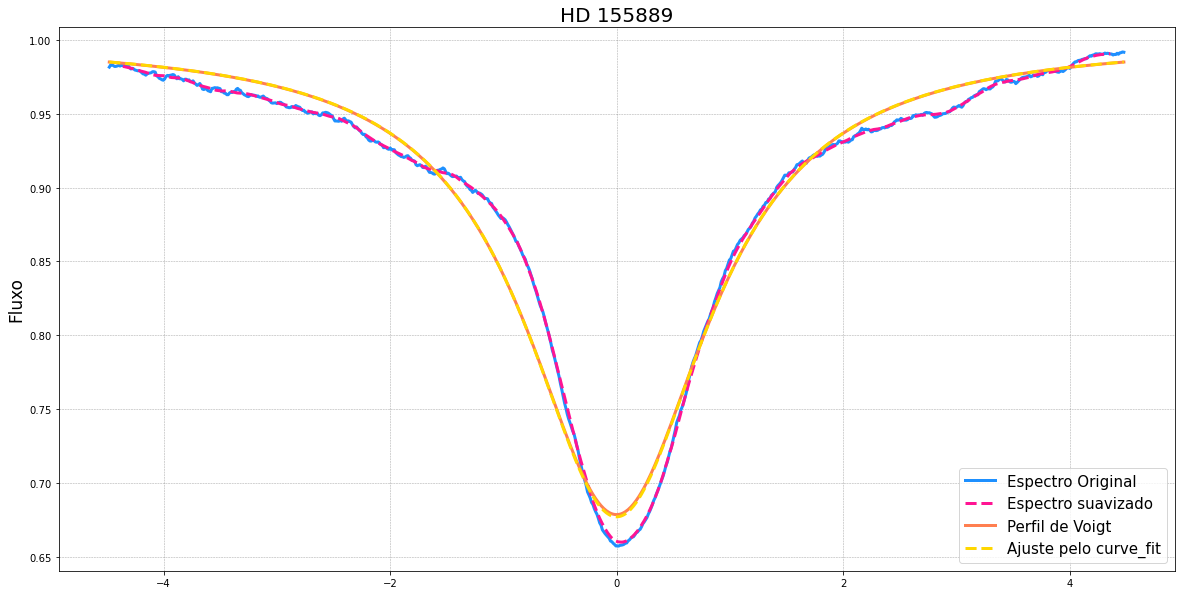

Valor da largura equivalente: 8.622e-01 ± 6.233e-10

--------------------------------- #### ----------------------------------------

Estrela:  HD 189957
O centro da linha de absorção está em: 4471.306


Testando as combinações de sigma e gamma: 100%|██████████| 1000/1000 [00:14<00:00, 71.15it/s]


Valor ideal de sigma: 7.267e-01
Valor ideal de gamma: 7.677e-01
Pelo curve_fit, o valor ideal de sigma é 7.246e-01 e o de gamma é 7.691e-01


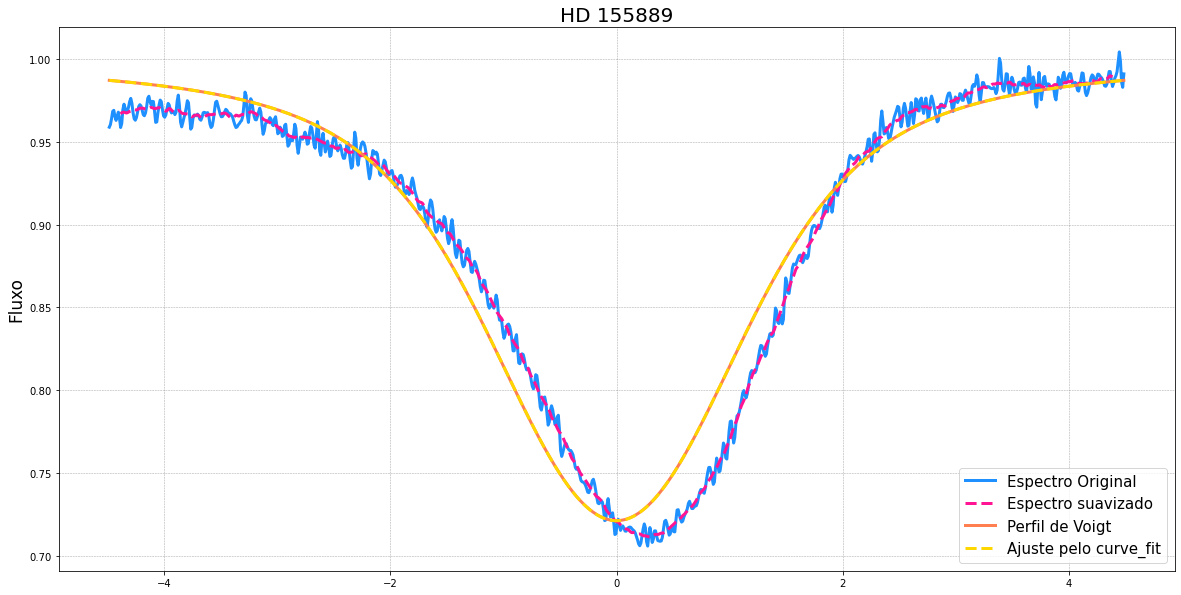

Valor da largura equivalente: 8.890e-01 ± 8.361e-11

--------------------------------- #### ----------------------------------------

Estrela:  HD 188209
O centro da linha de absorção está em: 4472.572


Testando as combinações de sigma e gamma: 100%|██████████| 1000/1000 [00:13<00:00, 72.48it/s]


Valor ideal de sigma: 6.987e-01
Valor ideal de gamma: 5.253e-01
Pelo curve_fit, o valor ideal de sigma é 6.977e-01 e o de gamma é 5.274e-01


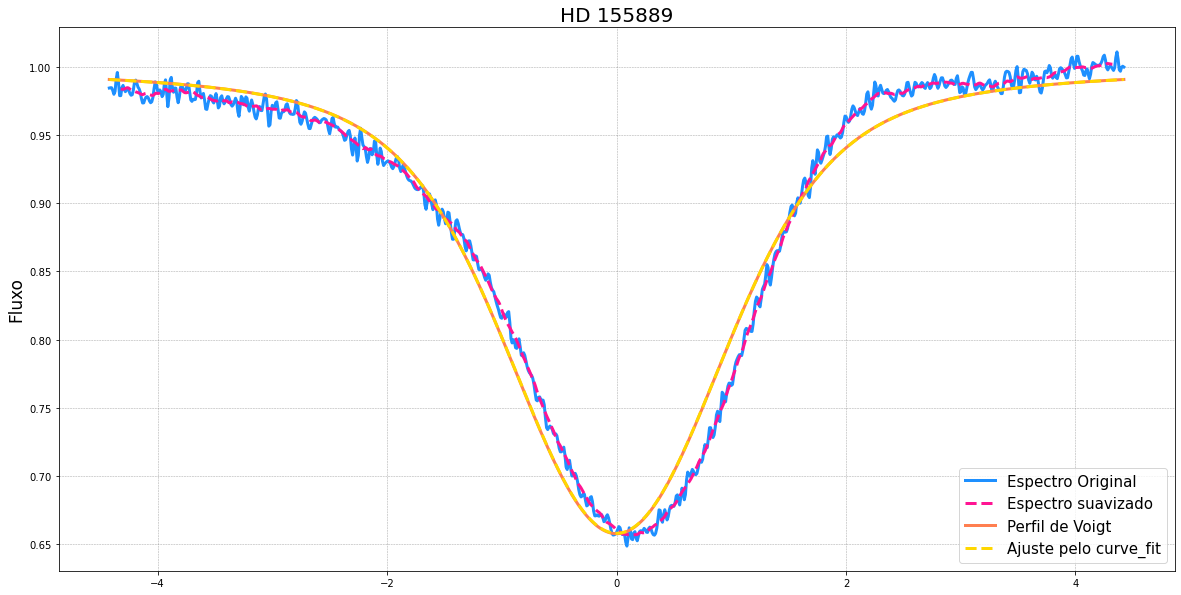

Valor da largura equivalente: 9.224e-01 ± 4.411e-09

--------------------------------- #### ----------------------------------------

Estrela:  HD 156154
O centro da linha de absorção está em: 4471.416


Testando as combinações de sigma e gamma: 100%|██████████| 1000/1000 [00:09<00:00, 107.28it/s]


Valor ideal de sigma: 3.804e-01
Valor ideal de gamma: 1.000e+00
Pelo curve_fit, o valor ideal de sigma é 1.149e-03 e o de gamma é 1.137e+00


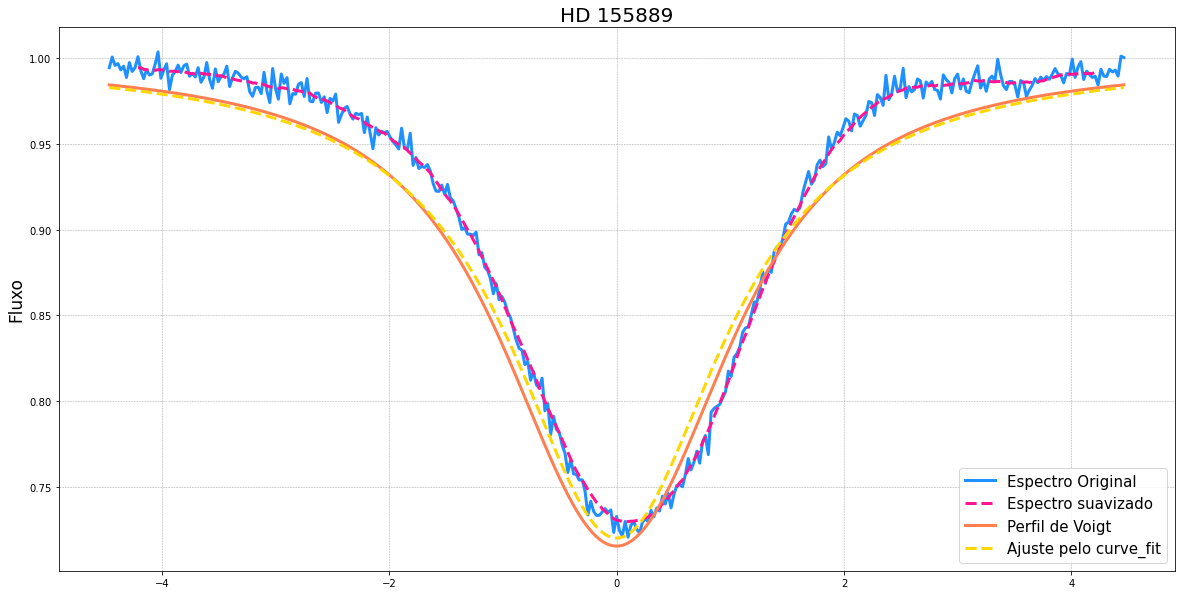

Valor da largura equivalente: 8.411e-01 ± 1.288e-11

--------------------------------- #### ----------------------------------------

Estrela:  HD 225160
O centro da linha de absorção está em: 4472.649


Testando as combinações de sigma e gamma: 100%|██████████| 1000/1000 [00:13<00:00, 73.97it/s]


Valor ideal de sigma: 5.966e-01
Valor ideal de gamma: 8.384e-01
Pelo curve_fit, o valor ideal de sigma é 5.982e-01 e o de gamma é 8.369e-01


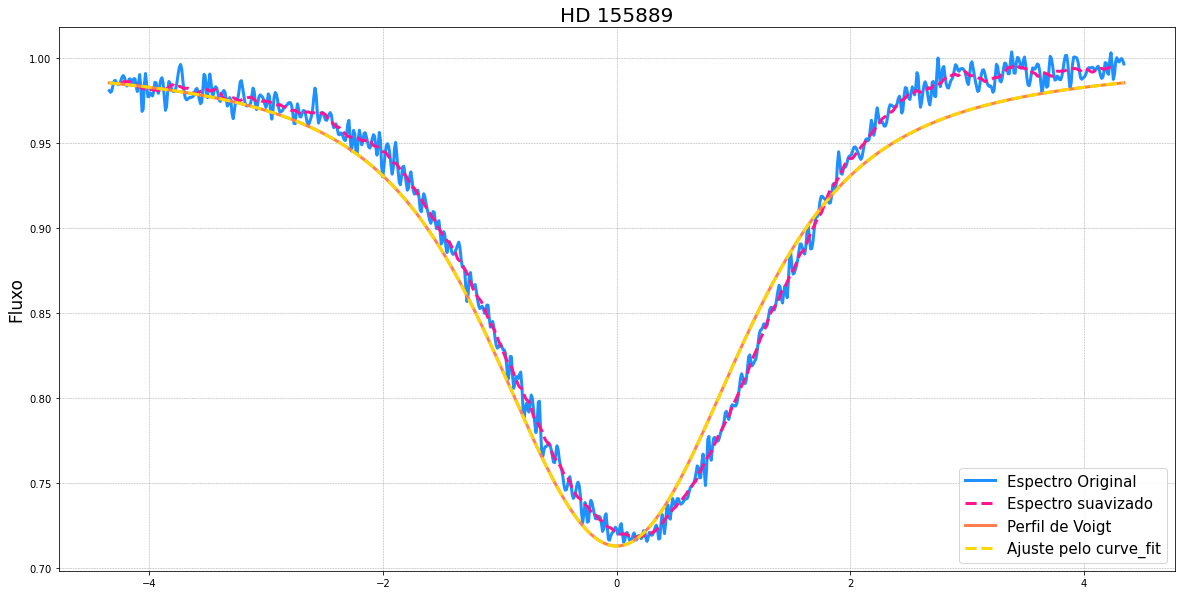

Valor da largura equivalente: 8.765e-01 ± 5.564e-09

--------------------------------- #### ----------------------------------------

Estrela:  HD 218915
O centro da linha de absorção está em: 4472.644


Testando as combinações de sigma e gamma: 100%|██████████| 1000/1000 [00:09<00:00, 105.39it/s]


Valor ideal de sigma: 4.144e-01
Valor ideal de gamma: 7.879e-01
Pelo curve_fit, o valor ideal de sigma é 4.148e-01 e o de gamma é 7.869e-01


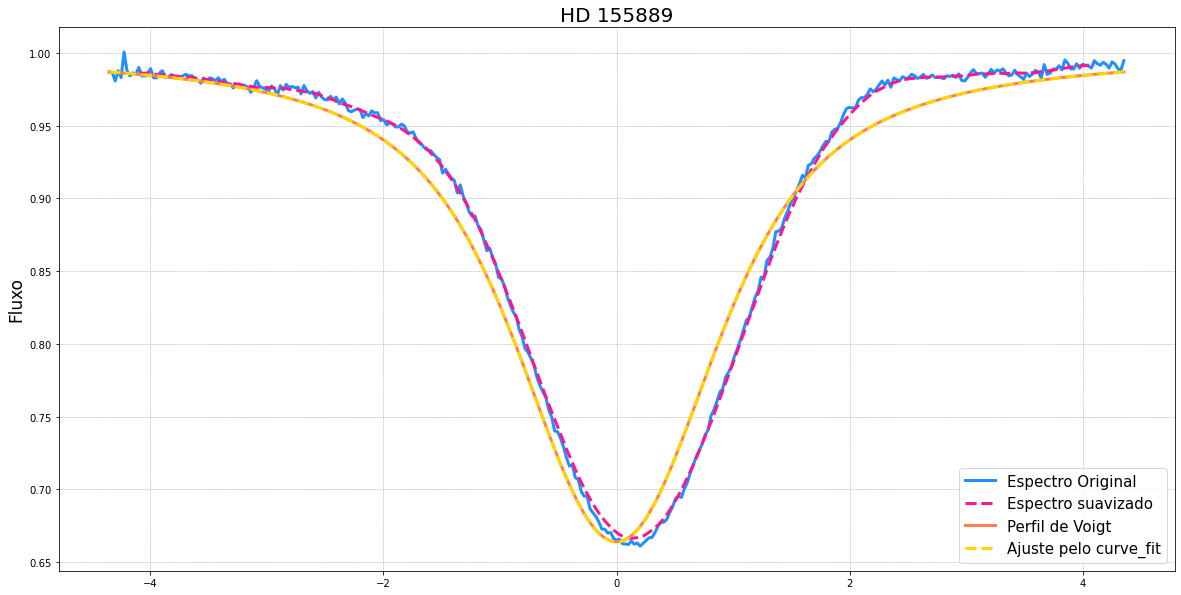

Valor da largura equivalente: 8.851e-01 ± 3.030e-13

--------------------------------- #### ----------------------------------------

Estrela:  HD 193322
O centro da linha de absorção está em: 4472.508


Testando as combinações de sigma e gamma: 100%|██████████| 1000/1000 [00:09<00:00, 105.76it/s]


Valor ideal de sigma: 8.428e-01
Valor ideal de gamma: 1.000e+00
Pelo curve_fit, o valor ideal de sigma é 1.434e-04 e o de gamma é 1.448e+00


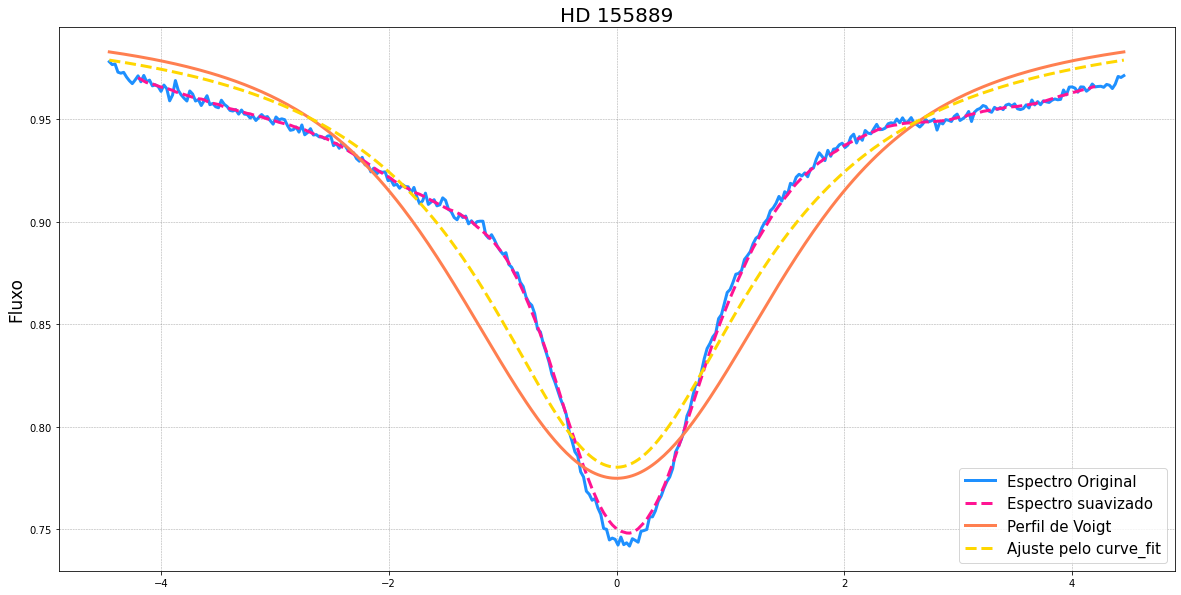

Valor da largura equivalente: 7.999e-01 ± 7.840e-09


In [23]:
for spectrum in estrelas:
    print('')
    print('--------------------------------- #### ----------------------------------------')
    print('')
    print("Estrela: ", star_name[estrelas.index(spectrum)])
    
    # Parte 1.
    
    archive=open('/Users/juliacamoesalves/Documents/Julia_Alves/Mestrado/Estágio de Docência/Espectros_ProjetoI/'+spectrum,"r")
    lines=archive.readlines()
    
    #Ler as linhas contidas no arquivo

    lambdas=[]
    flux=[]

    for i in lines:
        values = i.split() #Aqui separamos os valores de comprimento de onda e de fluxo
        if '4468' < values[0] < '4477':
            lambdas.append(float(values[0])) # Valores de comprimento de onda
            flux.append(float(values[1])) # Valores de fluxo
        else:
            continue

    archive.close()
    
    
    # Parte 2.
            
    lambdas = np.array(lambdas)
    flux = np.array(flux)

    c = center_spec(lambdas, flux)
    
    
    print('O centro da linha de absorção está em: {}'.format(round(c, 3)))

    x_center_index= int(np.where(lambdas == c)[0]) #Comprimento de onda central

    points= len(lambdas) - x_center_index # Quantidade de pontos até atingir o centro da linha
    
    x=[]
    y=[]

    for i in range((2*points)-1): # Termos o mesmo número de pontos em ambos os lados do centro da linha
        if (x_center_index-points+i) > 0: 
            x.append(lambdas[x_center_index-points+i]) #Intervalo de comprimento de onda centralizando a linha de absorção
            y.append(flux[x_center_index-points+i]) #Fluxos correspondentes a esses comprimentos de onda
        else:
            continue

        
    # Parte 3. 

    smooth_y=smooth(y, 20) #Fluxo suavizado    
    x=np.linspace(-(x[len(x)-1]-x[0])/2,(x[len(x)-1]-x[0])/2,len(x))
    
    
    # Parte 4.
        
    sigma = np.linspace(0.,2.,1000) #Lista de possíveis valores de sigma
    gamma = np.linspace(0.,1.,100) #Lista de possíveis valores de gamma

    sigma_teste = np.array([])
    gamma_teste = np.array([])

    S = np.array([])
    L = np.array([])


    for i in tqdm(range(len(sigma)), 'Testando as combinações de sigma e gamma: '):
        for j in range(len(gamma)):
            y_modelo = -scipy.special.voigt_profile(x, sigma[i], gamma[j])+1
            
            #Cálculo do resíduo para encontrar a combinação de sigma e gamma que gere a menor diferença entre modelo e observado
            residuo = smooth_y - y_modelo 
            sigma_teste = np.append(sigma_teste, sigma[i])
            gamma_teste = np.append(gamma_teste, gamma[j])
            S = np.append(S, np.sum(residuo**2))

    print('Valor ideal de sigma: {:.3e}'.format(sigma_teste[S.argmin()]))
    print('Valor ideal de gamma: {:.3e}'.format(gamma_teste[S.argmin()]))
    
    parameters, covariance = curve_fit(perfil_voigt, x, smooth_y) # curve_fit(função, x, y)

    print('Pelo curve_fit, o valor ideal de sigma é {:.3e} e o de gamma é {:.3e}'.format(parameters[0], parameters[1]))

    
    
    #Formaremos os gráficos com os diferentes ajustes, espectro observados e função de Voigt
        
    plt.figure(figsize=(20, 10))
    plt.plot(x, y, color='dodgerblue', linewidth=3, label='Espectro Original')
    plt.plot(x[10:-10], smooth_y[10:-10], color='deeppink', linestyle='--', label='Espectro suavizado',linewidth=3)
    plt.plot(x,perfil_voigt(x, sigma_teste[S.argmin()], gamma_teste[S.argmin()]), color='coral', label='Perfil de Voigt',linewidth=3)
    plt.plot(x,perfil_voigt(x, parameters[0], parameters[1]), label='Ajuste pelo curve_fit', color='gold', linestyle='--',linewidth=3)
    plt.title('HD 155889', fontsize= 20)
    plt.legend(loc='lower right', prop={'size':15})
    plt.rcParams['figure.figsize'] = (10,5)
    plt.ylabel("Fluxo", fontsize= 17)
    plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    plt.show()
    
    larg_equivalente = integrate.quad(lambda x: scipy.special.voigt_profile(x, parameters[0], parameters[1]),x[0], x[len(x)-1])
    
    larg_equivalente = integrate.quad(lambda x: scipy.special.voigt_profile(x, parameters[0], parameters[1]),x[0], x[len(x)-1])

    print(u'Valor da largura equivalente: {:.3e} \u00B1 {:.3e}'.format(larg_equivalente[0], larg_equivalente[1]))